# M1
Karl Jacobsen

## Introduction

## Franke-function

We start by importing the necessary Python modules:

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
import seaborn
seaborn.set(style="white", context="notebook", font_scale=1.5,
            rc={"axes.grid": True, "legend.frameon": False,
"lines.markeredgewidth": 1.4, "lines.markersize": 10})
from collections import OrderedDict
from scipy import linalg

We create data and plot the Franke-function with these data:

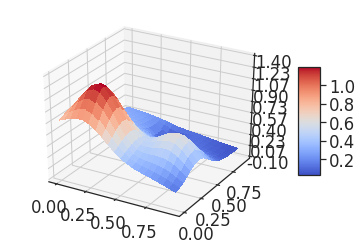

In [2]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def frankeNoise(z, noiseSize):
    return z+ noiseSize*np.random.randn(len(z))

# Make data.
x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)
xPlot, yPlot = np.meshgrid(x,y)
z = FrankeFunction(xPlot, yPlot)

# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Next we make a class, that has methods for computaion of the OLS and Ridge estimator. In order to avoid problems with singularity during the matrix inversions in the OLS and Ridge estimators, the SVD is used. The class also contains methods for computation of errors, parameter variances and different resempling techniques.

In [83]:
class LeastSquares:
    """ 
    Least squares estimation of 2D function.
    Takes in meshgrid versions of x, y and z
    """
    
    def __init__(self, xPlot, yPlot, zPlot, degree, trueFunction=False, lambdaValue=None):
        if trueFunction:
            self.trueFunction = trueFunction
        if lambdaValue != None:
            self.lambdaValue = lambdaValue
        else:
            self.lambdaValue = 0.
        self.xOrg, self.yOrg = xPlot[0], yPlot[:,0]
        self.numberOfObservations = len(self.xOrg)
        self.xPlot, self.yPlot, self.zPlot = xPlot, yPlot, zPlot
        #self.x, self.y, self.z = xPlot.reshape(-1, 1), yPlot.reshape(-1, 1), zPlot.reshape(-1, 1)
        #self.x, self.y, self.z = np.ravel(xPlot), np.ravel(yPlot), np.ravel(zPlot)
        self.x, self.y, self.z = np.reshape(xPlot, -1, 1), np.reshape(yPlot, -1, 1), np.reshape(zPlot, -1, 1)

        self.degree = degree
        
    def createDesignMatrix(self):
        x, y = self.x, self.y
        #XHat = np.c_[x, y] 
        self.XHat = np.c_[x, y] 
        poly = PolynomialFeatures(self.degree)
        self.XHat = poly.fit_transform(self.XHat)
        #self.XHat = poly.fit_transform(XHat)

    def estimate(self):
        XHat = self.XHat
        XHatTdotXHatShape = np.shape(XHat.T.dot(XHat))
        
        # Ridge Inverson
        #self.betaHat = np.linalg.inv(XHat.T.dot(XHat) + \
         #                            lambdaValue*np.identity(XHatTdotXHatShape[0])).dot(XHat.T).dot(self.z)
        
        # OLS inversion
        #self.betaHat = np.linalg.inv(XHat.T.dot(XHat)).dot(XHat.T).dot(self.z)
        
        # Linear system OLS
        #self.betaHat = np.linalg.solve(np.dot(XHat.T, XHat), np.dot(XHat.T, self.z))
        
        # Linear system, Ridge. NOT WORKING.
        #self.betaHat = np.linalg.solve(np.dot(XHat.T, XHat) + lambdaValue*np.identity(XHatTdotXHatShape[0]),\
         #                              np.dot(XHat.T, self.z))
        
        
        # SVD Ridge
        alphas = np.zeros(1)
        alphas[0] = self.lambdaValue
        U, s, Vt = linalg.svd(self.XHat, full_matrices=False)
        d = s / (s[:, np.newaxis].T ** 2 + alphas[:, np.newaxis])
        self.betaHat = np.dot(d * U.T.dot(self.z), Vt).T
        self.betaHat = np.squeeze(self.betaHat)
        #print('shape beta ', np.shape(self.betaHat), 'type beta', type(self.betaHat))
        
    
    def predict(self):
        self.zPredict = self.XHat.dot(self.betaHat)

        
    def plot(self):
        xPlot, yPlot, zPlot = self.xPlot, self.yPlot, self.zPlot
        zPredict = self.zPredict
        #z = self.z
        zPredictPlot = (np.reshape(zPredict, np.shape(zPlot))).T
        #zPredictPlot = zPredictPlot.T
        
        # Plot
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        surf = ax.plot_surface(xPlot, yPlot, zPredictPlot, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False) 
        #ax.set_zlim(-1.50, 25.0)
        #ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_title('Predicted')
        plt.show()
        
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        surf = ax.plot_surface(xPlot, yPlot, zPlot, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False) 
        #ax.set_zlim(-1.50, 25.0)
        #ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_title('True')
        plt.show()        
        
        
    def calculateErrorScores(self):
        from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
        z, zPredict = self.z, self.zPredict
        self.mse = mean_squared_error(z, zPredict)
        self.r2 = r2_score(z, zPredict)
        
        #print("Mean squared error: %.4f" % self.mse)
        #print('R2 score: %.4f' % self.r2)
        

    def calculateVarianceBeta(self):
        XHat = self.XHat
        betaHat = self.betaHat
        z = self.z

        # Source Ridge estimator variance: https://arxiv.org/pdf/1509.09169.pdf
        shapeXXT = np.shape(XHat.T.dot(XHat))

        yFitted = XHat.dot(betaHat)
        mse = 1/(len(x) -1)*np.sum((z - yFitted)**2)

        coefficientVariancesSLR = np.linalg.inv(XHat.T.dot(XHat)).dot(mse)
        W = np.linalg.inv(XHat.T.dot(XHat) + self.lambdaValue*np.eye(shapeXXT[0], shapeXXT[1])).dot(XHat.T).dot(XHat) 
        self.varBeta = W.dot(coefficientVariancesSLR).dot(W.T)
        self.varBeta = np.diag(self.varBeta)
        #self.varBeta = np.diag(coefficientVariancesSLR)
        self.varOLS = np.diag(coefficientVariancesSLR)
        
    def movingAvg(self, array):
        n = len(array)
        cumsum  = np.cumsum(array)
        movingAverage  = np.cumsum(array)
        for counter in range(len(array)):
            movingAverage[counter] = cumsum[counter]/(counter+1)
        return movingAverage    
    
    def runningVariance(self, betaList):
        betaList = np.array(betaList)
        numberOfRuns, numberOfBetas = np.shape(betaList)
        varianceMatrix = np.zeros((numberOfRuns, numberOfBetas))

        for runNumber in range(numberOfRuns):
            for betaNumber in range(numberOfBetas):
                varianceMatrix[runNumber, betaNumber] = np.var(betaList[0:runNumber+1, betaNumber])
        return varianceMatrix
    
    def runningVarianceVector(self, betaList):
        betaList = np.array(betaList)
        numberOfRuns = len(betaList)
        varianceVector = np.zeros(numberOfRuns)

        for runNumber in range(numberOfRuns):
            varianceVector[runNumber] = np.var(betaList[0:runNumber+1])
        return varianceVector
    
    

    
    def errorBootstrap(self, bootstraps=2, plot=False): 
        models = []
        
        self.mseBootstrap = np.zeros(bootstraps)
        self.R2Bootstrap = np.zeros(bootstraps)
        self.mseTraining = np.zeros(bootstraps)
        self.R2Training = np.zeros(bootstraps)
        
        self.bootstraps = bootstraps
        betaList = [] # For variance calculation
        #VBT = []
        self.error2 = np.zeros(bootstraps)
        #averageZ = 0
        zPredictDict = OrderedDict() # Bias-variance decomposition
        noiseDict = OrderedDict()
        noiseDict2 = OrderedDict()
        totalErrorDict = OrderedDict()
        varianceDict = OrderedDict()

        for i in range(self.numberOfObservations):
            for j in range(self.numberOfObservations):
                zPredictDict[i, j]  = []
                noiseDict[i, j]      = []
                #noiseDict2[i, j]      = []
                totalErrorDict[i, j] = []
        bias2Matrix = np.zeros((self.numberOfObservations, self.numberOfObservations))
        varianceMatrix = np.zeros_like(bias2Matrix)
        #varianceMatrix2 = np.zeros_like(bias2Matrix)
        noiseMatrix = np.zeros_like(bias2Matrix)
        #noiseMatrix2 = np.zeros_like(bias2Matrix)
        totalErrorMatrix = np.zeros_like(bias2Matrix)
        totalErrorMatrixForTesting = np.zeros_like(bias2Matrix)
        
        #avgYmatrix = np.zeros((self.numberOfObservations, self.numberOfObservations))
        zPredictMeanMatrix = np.zeros((self.numberOfObservations, self.numberOfObservations))

        
        for iteration in range(bootstraps):
            zPredictMatrix = np.zeros((self.numberOfObservations, self.numberOfObservations))
            # Training
            trainingIndices = [(np.random.randint(0, high=self.numberOfObservations), \
                      np.random.randint(0, high=self.numberOfObservations)) \
                     for i in range(self.numberOfObservations*self.numberOfObservations)]
            trainingIndices = np.array(trainingIndices)
            #print('\n trainingIndices \n', trainingIndices, '\n')
            '''
            xTraining1D = self.xPlot[trainingIndices[:,0], trainingIndices[:,1]]
            yTraining1D = self.yPlot[trainingIndices[:,0], trainingIndices[:,1]]
            zTraining1D = self.zPlot[trainingIndices[:,0], trainingIndices[:,1]]
            '''
            xTraining1D = self.xPlot[trainingIndices[:,1], trainingIndices[:,0]]
            yTraining1D = self.yPlot[trainingIndices[:,1], trainingIndices[:,0]]
            zTraining1D = self.zPlot[trainingIndices[:,1], trainingIndices[:,0]]
            
            self.x, self.y, self.z = xTraining1D, yTraining1D, zTraining1D        
            self.createDesignMatrix() # --> XHat
            self.estimate()           # --> betaHat
            betaList.append(self.betaHat)
            self.predict()
            self.mseTraining[iteration] = mean_squared_error(self.z, self.zPredict)
            self.R2Training[iteration] = r2_score(self.z, self.zPredict)
            
         
            # Testing
            testIndexArray = np.zeros((self.numberOfObservations, self.numberOfObservations))
            testIndexArray[trainingIndices[:,0], trainingIndices[:,1]] = 1
            testIndices = np.argwhere(testIndexArray == 0)
            #print('\n len(testIndices) \n', len(testIndices), '\n len(trainingIndices) \n', len(trainingIndices))
            '''
            xTest1D = self.xPlot[testIndices[:,0], testIndices[:,1]]
            yTest1D = self.yPlot[testIndices[:,0], testIndices[:,1]]
            zTest1D = self.zPlot[testIndices[:,0], testIndices[:,1]]
            '''
            
            xTest1D = self.xPlot[testIndices[:,1], testIndices[:,0]]
            yTest1D = self.yPlot[testIndices[:,1], testIndices[:,0]]
            zTest1D = self.zPlot[testIndices[:,1], testIndices[:,0]]
            
            #print('\n xTest1D \n', xTest1D, '\n')
            
            self.x, self.y, self.z = xTest1D, yTest1D, zTest1D
            self.createDesignMatrix()
            #self.estimate()
            self.predict()           # --> zPredict
            
            self.mseBootstrap[iteration] = mean_squared_error(self.z, self.zPredict)
            self.R2Bootstrap[iteration] = r2_score(self.z, self.zPredict)
            
            testIndicesTuple = tuple(map(tuple, testIndices))
            for coordinate, index in zip(testIndicesTuple, range(len(self.zPredict))):
                zPredictDict[coordinate].append(self.zPredict[index])
                noiseDict[coordinate].append((self.z[index] - self.trueFunction(self.x[index], self.y[index]))**2)
                #noiseDict2[coordinate].append(self.z[index] - self.trueFunction(self.x[index], self.y[index]))# Always the same
                totalErrorDict[coordinate].append((self.z[index] - self.zPredict[index])**2)
                zPredictMatrix[coordinate[0]][coordinate[1]] = self.zPredict[index]
            models.append(zPredictMatrix)
            
            self.error2[iteration] = 0            
            for i in range(len(x)):
                self.error2[iteration] += (self.z[i] - self.zPredict[i])**2
            

        
        #zForTest = np.ravel(self.zPlot)
        xForFunction, yForFunction = np.ravel(self.xPlot), np.ravel(self.yPlot)
        fValues = self.trueFunction(xForFunction, yForFunction)
        for key, index in zip(zPredictDict, range(len(zPredictDict))):
            zPredictMean = np.nanmean(zPredictDict[key])
            varianceMatrix[key[0], key[1]] = np.nanvar(zPredictDict[key])
            #varianceMatrix2[key[0], key[1]] = np.nanmean((zPredictDict[key] - zPredictMean)**2)
            #bias2Matrix[key[0], key[1]] = (zPredictMean - self.trueFunction(self.xOrg[key[0]], self.yOrg[key[1]]))**2
            #bias2Matrix[key[0], key[1]] = (zPredictMean - zForTest[index])**2
            bias2Matrix[key[0], key[1]] = (zPredictMean - fValues[index])**2
            noiseMatrix[key[0], key[1]] = np.nanmean(noiseDict[key])
            #noiseMatrix2[key[0], key[1]] = np.nanvar(noiseDict2[key])
            totalErrorMatrix[key[0], key[1]] = np.nanmean(totalErrorDict[key])
            totalErrorMatrixForTesting[key[0], key[1]] = varianceMatrix[key[0], key[1]] + bias2Matrix[key[0], key[1]]\
                                                        + noiseMatrix[key[0], key[1]]
                    
            zPredictMeanMatrix[key[0], key[1]] = np.nanmean(zPredictDict[key])

            

        #print('\n varianceMatrix/varianceMatrix2 \n', np.divide(varianceMatrix,varianceMatrix2), '\n ') 
        # Result: they equal
        
        #print('\n totalErrorMatrix/totalErrorMatrixForTesting \n', np.divide(totalErrorMatrix,totalErrorMatrixForTesting), '\n ') 
        # Result: different
        
        #print('\n noiseMatrix/noiseMatrix2 \n', np.divide(noiseMatrix,noiseMatrix2), '\n ') 
        # Result: Numbers ar 10**31
        
        #print('\n noiseMatrix2 \n',noiseMatrix2, '\n ') 
        # Very small elements, 10**-31 --> Reason: The difference between the real function and the data always the same
        
        # bias-variance over all observations
        self.bias2 = np.nanmean(np.reshape(bias2Matrix, -1, 1))
        self.variance = np.nanmean(np.reshape(varianceMatrix, -1, 1))
        #self.variance2 = np.nanmean(np.reshape(varianceMatrix2, -1, 1))
        self.noise = np.nanmean(np.reshape(noiseMatrix, -1, 1))
        self.totalError = np.nanmean(np.reshape(totalErrorMatrix, -1, 1))
        self.totalErrorForTesting = np.nanmean(np.reshape(totalErrorMatrixForTesting, -1, 1))
        #print('\n bias2, variance, noise, sum(bias2, variance, noise), totalError', 
         #     self.bias2, self.variance, self.noise, self.bias2+ self.variance+self.noise, self.totalError) 
        
        from numpy.linalg import norm
        
        zPredictMeanMatrix = np.reshape(zPredictMeanMatrix, -1, 1)
        bias_2 = norm(zPredictMeanMatrix - fValues)/fValues.size #example python
        
        
        #betaList = np.array(betaList)
        self.error2 = np.sum(self.error2)
        self.mseBootStrapMA = self.movingAvg(self.mseBootstrap)
        self.R2BootstrapMA = self.movingAvg(self.R2Bootstrap)
        self.betaRunning = self.movingAvg(betaList)
        self.varianceBetaBootstrap =  self.runningVariance(betaList)
        self.varMSE = self.runningVarianceVector(self.mseBootstrap)
        #self.VBT = np.array(VBT)
        #self.totalVBT = self.VBT[:,-1]
        
        if plot:
            fig, ax = plt.subplots()
            ax.plot(np.arange(1,len(self.mseBootStrapMA)+1), self.mseBootStrapMA)
            ax.set_title('Bootstrap \n Running Mean MSE')
            ax.set_xlabel('Number of bootsraps')
            ax.set_ylabel('Running mean MSE')
            
            fig4, ax4 = plt.subplots()
            ax4.plot(np.arange(1,len(self.mseBootStrapMA)+1), (self.varMSE/self.mseBootStrapMA)*100)
            ax4.set_title('Bootstrap \n Running (Variance MSE/Mean MSE)*100')
            ax4.set_xlabel('Number of bootsraps')
            ax4.set_ylabel('Running variance MSE')
            
            fig2, ax2 = plt.subplots()
            ax2.plot(np.arange(1,len(self.R2BootstrapMA )+1), self.R2BootstrapMA )
            ax2.set_title('Bootstrap \n Running Mean R2')
            ax2.set_xlabel('Number of bootsraps')
            ax2.set_ylabel('Running Mean R2')
            
            fig3, ax3 = plt.subplots()
            ax3.plot(np.arange(1,len(self.R2BootstrapMA )+1), self.varianceBetaBootstrap )
            ax3.set_title('Bootstrap \n Var(Beta) (Running)')
            ax3.set_xlabel('Number of bootsraps')
            ax3.set_ylabel('Var(Beta)')
            
            '''
            fig5, ax5 = plt.subplots()
            ax5.plot(np.arange(1,len(self.R2BootstrapMA )+1),  self.betaRunning)
            ax5.set_title('Bootstrap \n Beta')
            ax5.set_xlabel('Number of bootsraps')
            ax5.set_ylabel('Beta')
            '''
            # HERE: 1) After reversal of index numbers, total error in bootstrap no longer sum of bias and viarnace
            # when zero noise, \
            #2) maybe possible use method as in pytjhon nb example. Just take average each
            # element.., 
            
    def kFold(self, numberOfFolds=3, shuffle=False):
        betaList = [] # For variance calculation
        self.zPredictDict = OrderedDict() # Bias-variance decomposition
        self.mseTraining = np.zeros(numberOfFolds)
        self.R2Training = np.zeros(numberOfFolds)        
        noiseDict = OrderedDict()
        totalErrorDict = OrderedDict()
        varianceDict = OrderedDict()
        self.mseSciKit = np.zeros(numberOfFolds)
        self.R2SciKit = np.zeros(numberOfFolds)
        bias2Matrix = np.zeros((self.numberOfObservations, self.numberOfObservations))
        varianceMatrix = np.zeros_like(bias2Matrix)
        noiseMatrix = np.zeros_like(bias2Matrix)
        totalErrorMatrix = np.zeros_like(bias2Matrix)
        totalErrorMatrixForTesting = np.zeros_like(bias2Matrix)    
        
        for i in range(self.numberOfObservations):
            for j in range(self.numberOfObservations):
                self.zPredictDict[i, j]   = []
                noiseDict[i, j]      = []
                totalErrorDict[i, j] = []
        
        if not shuffle:
            indices = []
            for i in range(self.numberOfObservations):
                for j in range(self.numberOfObservations):
                    indices.append((i,j))
            indices = np.array(indices)
        else:
            return None
        
        foldLength = int(round(self.numberOfObservations**2/numberOfFolds))
        
        for iteration in range(numberOfFolds):
            if iteration != range(numberOfFolds)[-1]:
                testIndices = indices[iteration*foldLength:(iteration+1)*foldLength]
            else:
                testIndices = indices[foldLength*iteration:]   
            
            
            xTest1D = self.xPlot[testIndices[:,1], testIndices[:,0]]
            yTest1D = self.yPlot[testIndices[:,1], testIndices[:,0]]
            zTest1D = self.zPlot[testIndices[:,1], testIndices[:,0]]
            '''
            print('\n testIndices \n',testIndices)
            print('\n xPlot \n',self.xPlot)
            print('\n xTest1D \n',xTest1D)

            print('\n testIndices \n',testIndices)
            print('\n yPlot \n',self.yPlot)
            print('\n yTest1D \n',yTest1D)
            '''
            
            indices_rows = indices.view([('', indices.dtype)] * indices.shape[1])
            testIndices_rows = testIndices.view([('', testIndices.dtype)] * testIndices.shape[1])
            trainingIndices = np.setdiff1d(indices_rows, testIndices_rows).view(indices.dtype).reshape(-1, indices.shape[1])          
            #print('\n trainingIndices \n',trainingIndices)
            #print('\n testIndices \n',testIndices)
            xTraining1D = self.xPlot[trainingIndices[:,1], trainingIndices[:,0]]
            yTraining1D = self.yPlot[trainingIndices[:,1], trainingIndices[:,0]]
            zTraining1D = self.zPlot[trainingIndices[:,1], trainingIndices[:,0]]

            self.x, self.y, self.z = xTraining1D, yTraining1D, zTraining1D      
            #print('\n self.x \n', self.x)
            
            self.createDesignMatrix() # --> XHat
            self.estimate()           # --> betaHat
            betaList.append(self.betaHat)
            self.predict()
            self.mseTraining[iteration] = mean_squared_error(self.z, self.zPredict)
            self.R2Training[iteration] = r2_score(self.z, self.zPredict)
            
            self.x, self.y, self.z = xTest1D, yTest1D, zTest1D
            self.createDesignMatrix()
            self.predict()           # --> zPredict
            self.mseSciKit[iteration] = mean_squared_error(self.z, self.zPredict)
            self.R2SciKit[iteration] = r2_score(self.z, self.zPredict)
            
            testIndicesTuple = tuple(map(tuple, testIndices))
            for coordinate, index in zip(testIndicesTuple, range(len(self.zPredict))):
                self.zPredictDict[coordinate].append(self.zPredict[index])
                noiseDict[coordinate].append((self.z[index] - self.trueFunction(self.x[index], self.y[index]))**2)
                totalErrorDict[coordinate].append((self.z[index] - self.zPredict[index])**2)
        #print('\n zPredictDict inside ', self.zPredictDict)
        xForFunction, yForFunction = np.ravel(self.xPlot), np.ravel(self.yPlot)
        fValues = self.trueFunction(xForFunction, yForFunction)
        for key, index in zip(self.zPredictDict, range(len(self.zPredictDict))):
            zPredictMean = np.nanmean(self.zPredictDict[key])
            varianceMatrix[key[0], key[1]] = np.nanvar(self.zPredictDict[key])
            bias2Matrix[key[0], key[1]] = (zPredictMean - fValues[index])**2
            noiseMatrix[key[0], key[1]] = np.nanmean(noiseDict[key])
            totalErrorMatrix[key[0], key[1]] = np.nanmean(totalErrorDict[key])
            totalErrorMatrixForTesting[key[0], key[1]] = varianceMatrix[key[0], key[1]] + bias2Matrix[key[0], key[1]]\
                                                        + noiseMatrix[key[0], key[1]]
            
        # bias-variance over all observations
        self.bias2 = np.nanmean(np.reshape(bias2Matrix, -1, 1))
        self.variance = np.nanmean(np.reshape(varianceMatrix, -1, 1))
        self.noise = np.nanmean(np.reshape(noiseMatrix, -1, 1))
        self.totalError = np.nanmean(np.reshape(totalErrorMatrix, -1, 1))
        self.totalErrorForTesting = np.nanmean(np.reshape(totalErrorMatrixForTesting, -1, 1))
        

### Model selection
We will approximate the Franke function with polynomial regression. In order to decide which polynomial order to use, we make comparisons of the results using different polynomial degrees in the training. The copmarisions are made on error measures such as the Mean Squared Error (MSE) and the R2 score. <br>

By comparing the performance of different polynomial degrees by MSE and R2 from traning data, one will probaly not find the best model. The error measures for the training data typically always decreases with the complexity of the model, leading to the false conclusion that the more complex the model, the better. The problem with a highly complex model, is that the predictions from this model will be highly variable with the input. A model very senesitive to the input data, does not generalize well, meaning that the model does not work well for other data than the data it was created with. This problem is called overfitting. <br>

Overfitting can be measured by measruing the preiction error from a given model on data that was not used in estimating the model. We split the data in training and test sets. Techniques for splitting the data in test and training sets are called resampling techniques. <br>

We will apply two different resampling techniques: K-fold and Bootstrapping. With the F-fold method, the data is split in K number of folds. One of the folds are chosen as the testing set, while the remaining folds are used for traning the model. This is repeated K number of times, each time with a different fold as the test set. We get K models, and we compute the error measures for all of them. Finally we averge the error measures over the models, getting scalars for the error measures for the given polynoial degree. <br>

With Bootstrapping, the other resampling technique, the data set is split into test and tranining set by random drawing. The tranining observations are drawn from the full dataset, with replacement. The number of observations in the training set equals the number of observations in the full data set. The replacement and the size of the training set implies that there almost always will be duplicats in the training set. The observations not contained in the training set makes up the test set. Typcally the split is 65/35 for training/test observations.<br>

The next figure shows $MSE_{training}$ and $MSE_{testing}$ as functions of the polynomial degree.

### MSE: Bootstrap, K-fold, training

In [82]:
np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)
xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)
noiseSize  = 0.
zPlot = frankeNoise(zPlot, noiseSize)

maxDegree = 7
degrees = np.arange(1, maxDegree+1)
bootstraps = 100
numberOfFolds = 10
biasBS, varianceBS, noiseBS, totalErrorBS, mseBS, mseTrainingBS, r2BS = [], [], [], [], [], [], []
biasKF, varianceKF, noiseKF, totalErrorKF, mseKF, mseTrainingKF, r2KF, mseKFStd = [], [], [], [], [], [], [], []
R2training, mseTraining = [], []

for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    ls.createDesignMatrix()
    ls.estimate()
    ls.predict()
    ls.calculateErrorScores()
    mseTraining.append(ls.mse)
    R2training.append(ls.r2)
    
    lsBS = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    lsBS.errorBootstrap(bootstraps=bootstraps, plot=False)
    biasBS.append(lsBS.bias2)
    varianceBS.append(lsBS.variance)
    noiseBS.append(lsBS.noise)
    totalErrorBS.append(lsBS.totalError)
    mseBS.append(np.mean(lsBS.mseBootstrap))
    mseTrainingBS.append(np.mean(lsBS.mseTraining))
    r2BS.append(np.mean(lsBS.R2Bootstrap))
   
    lsKF = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    lsKF.kFold(numberOfFolds=numberOfFolds)
    biasKF.append(lsKF.bias2)
    varianceKF.append(lsKF.variance)
    noiseKF.append(lsKF.noise)
    totalErrorKF.append(lsKF.totalError)
    mseKF.append(np.mean(lsKF.mseSciKit))
    mseKFStd.append(np.std(lsKF.mseSciKit)/np.mean(lsKF.mseSciKit))
    mseTrainingKF.append(np.mean(lsKF.mseTraining))
    r2KF.append(np.mean(lsKF.R2SciKit))


    
print(mseBS)
print(mseKF)


 zPredictMatrix 
 [[ 0.          0.          0.          0.90847191  0.85827992  0.
   0.          0.          0.          0.49550118  0.          0.4914135
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.89503216  0.          0.74401621
   0.          0.          0.          0.48206143  0.          0.
   0.          0.40184558  0.          0.34873195  0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.71200953
   0.71054102  0.          0.55771893  0.45005474  0.44627987  0.44596706
   0.          0.          0.          0.31672526  0.31549415  0.
   0.2595      0.        ]
 [ 0.89556101  0.          0.84868852  0.          0.          0.
   0.          0.61272254  0.53404157  0.          0.42260251  0.
   0.          0.          0.32237201  0.          0.          0.28025653
   0.23582264  0.        ]
 [ 0.          0.87784136  0.          0. 


 zPredictMatrix 
 [[ 0.          0.          0.          0.91342885  0.86374358  0.
   0.76248382  0.6890912   0.61120457  0.          0.          0.
   0.46039144  0.          0.40167195  0.37264388  0.          0.
   0.          0.30878717]
 [ 0.          0.94069916  0.90873382  0.89948772  0.          0.74999637
   0.          0.67515007  0.59726343  0.          0.          0.
   0.          0.          0.          0.35870275  0.35748407  0.
   0.30205521  0.        ]
 [ 0.92193237  0.          0.          0.86628699  0.          0.71679564
   0.          0.64194934  0.          0.45748545  0.          0.45343904
   0.41324957  0.          0.          0.          0.32428334  0.
   0.          0.        ]
 [ 0.8973717   0.          0.          0.84172632  0.          0.
   0.69078129  0.61738867  0.          0.          0.          0.42887837
   0.3886889   0.          0.          0.          0.          0.
   0.24429381  0.23708464]
 [ 0.          0.          0.84771683  0.        


 zPredictMatrix 
 [[ 0.00000000e+00  0.00000000e+00  9.23315078e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.58114626e-01  0.00000000e+00
   6.02104735e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  4.10305601e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  3.43025847e-01  2.97665089e-01  0.00000000e+00]
 [ 9.57647512e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   8.49023065e-01  0.00000000e+00  7.44596829e-01  0.00000000e+00
   0.00000000e+00  4.78676922e-01  0.00000000e+00  4.74503973e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  3.29508050e-01  0.00000000e+00  0.00000000e+00]
 [ 9.25454961e-01  0.00000000e+00  8.77604731e-01  8.68069496e-01
   0.00000000e+00  0.00000000e+00  7.12404279e-01  0.00000000e+00
   5.56394388e-01  4.46484371e-01  4.42630755e-01  4.42311422e-01
   4.00865195e-01  0.00000000e+00  3.40309494e-01  0.00000000e+00
   3.09116905e-01  0.00000000e+00  0.00000000e+00  2.44


 zPredictMatrix 
 [[ 0.          0.95485869  0.          0.91240449  0.          0.75840515
   0.          0.          0.          0.          0.          0.
   0.          0.40947477  0.38521527  0.35531185  0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.84763399  0.
   0.          0.          0.          0.47768838  0.          0.47351995
   0.43211855  0.39588783  0.          0.          0.          0.
   0.          0.27594257]
 [ 0.92378375  0.          0.87598527  0.          0.          0.
   0.71096349  0.          0.          0.          0.44148173  0.
   0.          0.          0.          0.30936771  0.          0.
   0.          0.24358536]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.61142101  0.53118566  0.42139452  0.          0.
   0.          0.          0.31533447  0.28543105  0.          0.
   0.22707528  0.2196487 ]
 [ 0.89667421  0.          0.84887573  0.83935081  0.          0.


 zPredictMatrix 
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.75299343  0.64244881  0.          0.          0.46788098
   0.39935701  0.33715938  0.2943485   0.          0.          0.
   0.13071726  0.11638465]
 [ 0.          0.          0.          0.          0.94395683  0.
   0.83119158  0.          0.          0.          0.          0.
   0.          0.33107379  0.28899842  0.23584915  0.          0.
   0.          0.        ]
 [ 0.          0.97597889  0.          0.          0.89622237  0.
   0.          0.70392273  0.          0.          0.43920412  0.43871943
   0.          0.          0.27563302  0.          0.          0.
   0.          0.10747902]
 [ 0.          0.          0.          0.          0.          0.76223549
   0.          0.          0.57962164  0.          0.          0.42282405
   0.36075599  0.30420798  0.26517999  0.          0.21368239  0.19379706
   0.11531142  0.        ]
 [ 0.          0.          0.          0.

  0.02227907 0.        ]]

 zPredictMatrix 
 [[1.05529295 0.         1.00073523 0.         0.         0.
  0.80335107 0.         0.         0.         0.         0.
  0.         0.         0.         0.26451382 0.         0.24562196
  0.         0.16834893]
 [0.         1.01668591 0.97981269 0.         0.         0.
  0.78663044 0.         0.59134364 0.         0.44106806 0.
  0.3842321  0.         0.30023684 0.25801892 0.25623643 0.
  0.         0.        ]
 [0.         0.         0.92994674 0.91975467 0.86418747 0.
  0.7467713  0.65817239 0.56093461 0.42251574 0.         0.4171383
  0.36324407 0.         0.         0.24251229 0.         0.22474355
  0.16233999 0.1520114 ]
 [0.         0.92642161 0.         0.88325757 0.         0.71890762
  0.         0.63204227 0.         0.         0.         0.
  0.         0.         0.27006884 0.         0.         0.
  0.         0.        ]
 [0.93613944 0.         0.         0.         0.82545069 0.
  0.71333415 0.         0.53541495 0.       


 zPredictMatrix 
 [[1.07529286 0.         0.         0.         0.         0.
  0.         0.         0.         0.48986433 0.         0.48357794
  0.42002861 0.         0.         0.         0.27216299 0.25242449
  0.17503091 0.        ]
 [0.         0.         1.00336399 0.         0.         0.
  0.         0.73603099 0.63171452 0.47667276 0.         0.
  0.40814771 0.35191914 0.31340434 0.26497436 0.         0.
  0.         0.        ]
 [0.98476464 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.38046541 0.         0.28986536 0.         0.24151333 0.22292136
  0.14993468 0.        ]
 [0.         0.9263578  0.         0.         0.84523548 0.
  0.         0.         0.         0.42363645 0.         0.41796669
  0.         0.         0.         0.         0.         0.
  0.         0.12573119]
 [0.         0.         0.         0.         0.         0.73954905
  0.73799624 0.65616202 0.         0.         0.         0.
 


 zPredictMatrix 
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.73235225  0.62968402  0.47505313  0.46933497  0.
   0.40607267  0.34922002  0.3101576   0.26090939  0.25881529  0.23904722
   0.16131123  0.1483048 ]
 [ 0.          0.          0.          0.95811967  0.          0.
   0.80388399  0.          0.          0.46457125  0.          0.
   0.39674761  0.          0.          0.25387901  0.25181678  0.23234797
   0.          0.14294434]
 [ 0.          0.          0.          0.          0.86349903  0.
   0.          0.68045188  0.58467113  0.          0.43407709  0.
   0.37439611  0.          0.28367356  0.2369923   0.          0.
   0.14240344  0.        ]
 [ 0.          0.90196395  0.          0.          0.82825082  0.7336198
   0.          0.          0.56105771  0.42076154  0.41554599  0.
   0.          0.          0.26971359  0.          0.2224395   0.
   0.          0.        ]
 [ 0.90725165  0.89672827  0.87235623  0.8650324   0.     


 zPredictMatrix 
 [[0.         0.91075878 0.         0.         0.         0.
  0.         0.         0.         0.32481418 0.31971166 0.
  0.         0.         0.25515096 0.         0.         0.
  0.34765557 0.3633539 ]
 [0.         0.9181336  0.95167434 0.95724059 0.         0.84765468
  0.84519377 0.70180289 0.53161472 0.33360355 0.32838574 0.
  0.         0.         0.         0.         0.         0.28249231
  0.34801197 0.        ]
 [0.         0.         0.         0.96071839 0.         0.859709
  0.         0.71515524 0.         0.34162009 0.         0.33572377
  0.         0.         0.25975694 0.         0.         0.
  0.         0.        ]
 [0.         0.90300356 0.94203675 0.         0.95760781 0.
  0.85352558 0.         0.         0.         0.33181056 0.
  0.         0.         0.         0.         0.         0.
  0.32234196 0.33604788]
 [0.87443613 0.90018699 0.         0.         0.         0.85466122
  0.         0.         0.5414053  0.         0.33067155 0.
  0


 zPredictMatrix 
 [[0.88997165 0.         0.         0.         0.96974277 0.85710312
  0.         0.         0.52297353 0.         0.30705094 0.30660088
  0.25903021 0.         0.         0.         0.25105654 0.
  0.         0.        ]
 [0.89802551 0.92519747 0.         0.         0.9819807  0.
  0.         0.71866988 0.         0.32511583 0.31948288 0.
  0.         0.24755434 0.24491617 0.         0.         0.26858677
  0.         0.        ]
 [0.         0.92676393 0.         0.97996991 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.25181601 0.26110966 0.         0.
  0.         0.        ]
 [0.         0.91220671 0.96005193 0.         0.         0.
  0.88506865 0.         0.         0.3398355  0.         0.33335521
  0.         0.         0.2462317  0.2535051  0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.98413764 0.
  0.         0.         0.55803455 0.33913106 0.33312476 0.33263406
 


 zPredictMatrix 
 [[0.         0.         0.         0.         0.         0.
  0.87283078 0.         0.         0.         0.33327588 0.
  0.         0.         0.         0.         0.         0.27384634
  0.34000171 0.        ]
 [0.86873632 0.         0.95179512 0.         0.         0.88961852
  0.         0.74385477 0.56554171 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.35895488]
 [0.         0.90895233 0.         0.97242644 0.         0.
  0.         0.75980936 0.         0.         0.35419702 0.
  0.         0.27107181 0.         0.         0.         0.
  0.         0.        ]
 [0.86408066 0.         0.         0.         0.98888385 0.
  0.         0.         0.57769748 0.35569266 0.         0.34900489
  0.         0.26352938 0.         0.         0.         0.26826789
  0.32529197 0.        ]
 [0.         0.89543541 0.         0.96147706 0.98708595 0.
  0.89817905 0.         0.57660911 0.         0.34821296 0.
  0.29184


 zPredictMatrix 
 [[0.         0.         0.93462519 0.         0.95239975 0.848321
  0.         0.70088444 0.         0.         0.31051244 0.31005506
  0.         0.23717161 0.2332211  0.24332934 0.24414229 0.
  0.31785896 0.33312096]
 [0.         0.         0.94618926 0.         0.96555557 0.
  0.86077101 0.         0.         0.3297423  0.         0.
  0.         0.         0.         0.         0.         0.26271846
  0.         0.34031874]
 [0.         0.90791249 0.95346027 0.         0.97712399 0.87972504
  0.         0.         0.         0.         0.         0.33919946
  0.         0.         0.25406688 0.         0.         0.26951446
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.87443883 0.         0.         0.         0.         0.
  0.         0.         0.2491124  0.25462262 0.         0.
  0.         0.33242367]
 [0.         0.         0.9400121  0.94934818 0.         0.87551139
  0.         0.         0.         0.         0


 zPredictMatrix 
 [[ 0.          0.70561619  0.          0.81231986  0.8556704   0.75978461
   0.          0.61167949  0.45369264  0.          0.          0.
   0.26856442  0.25674064  0.25497113  0.          0.          0.
   0.          0.28206156]
 [ 0.74507153  0.79904782  0.          0.          0.93678405  0.
   0.          0.          0.          0.33608114  0.33225173  0.
   0.29993764  0.28516671  0.          0.          0.28354248  0.28587248
   0.          0.        ]
 [ 0.          0.93219427  1.01013696  0.          1.04994502  0.
   0.          0.74129448  0.          0.          0.          0.
   0.          0.          0.30145628  0.          0.          0.
   0.          0.        ]
 [ 0.91460323  0.          0.          1.05417727  0.          0.
   0.          0.74980881  0.          0.          0.          0.
   0.31633286  0.          0.28753603  0.          0.          0.28654494
   0.          0.        ]
 [ 0.          0.9655728   1.0411807   0.          0.    


 zPredictMatrix 
 [[ 0.          0.          0.          0.8256369   0.          0.
   0.          0.          0.          0.          0.27714259  0.27683187
   0.          0.23878077  0.24263103  0.          0.          0.
   0.31648776  0.        ]
 [ 0.          0.80447043  0.89936118  0.          0.          0.86015627
   0.          0.69278035  0.          0.32253707  0.          0.
   0.28353552  0.          0.2721209   0.          0.28413029  0.
   0.          0.34406427]
 [ 0.          0.94496416  1.03067942  1.04711866  0.          0.95368771
   0.          0.          0.57302474  0.36778164  0.36281587  0.
   0.          0.          0.          0.30209892  0.30253882  0.30753909
   0.          0.34772693]
 [ 0.          0.          1.05959664  1.0749383   1.10371568  0.
   0.96434277  0.7803447   0.57691099  0.36477495  0.          0.35911923
   0.31408251  0.          0.          0.          0.          0.
   0.31994789  0.3263308 ]
 [ 0.          0.          0.          1.

  0.         0.        ]]

 zPredictMatrix 
 [[0.         0.7342309  0.82642614 0.         0.         0.
  0.         0.6317138  0.         0.         0.         0.
  0.         0.23868126 0.23767481 0.24435436 0.24481365 0.24978332
  0.         0.        ]
 [0.         0.         0.         0.93023328 0.96917432 0.85655271
  0.         0.         0.         0.         0.32356906 0.32322043
  0.28731396 0.         0.         0.27237833 0.         0.27675352
  0.         0.        ]
 [0.         0.9522592  0.         0.         1.07585045 0.94296321
  0.         0.7624429  0.         0.36988859 0.         0.
  0.3227336  0.30152006 0.         0.         0.         0.29797063
  0.31730829 0.        ]
 [0.         0.         1.05766989 0.         1.0957393  0.
  0.         0.         0.57056204 0.         0.         0.35991817
  0.31576126 0.         0.28495683 0.         0.         0.28554208
  0.         0.        ]
 [0.         0.98037677 1.0576816  0.         0.         0.
  0.9508445


 zPredictMatrix 
 [[ 0.6319978   0.          0.          0.          0.          0.
   0.          0.          0.          0.27761682  0.27418413  0.
   0.          0.          0.24474409  0.          0.          0.
   0.30772051  0.        ]
 [ 0.          0.79089157  0.          0.89699989  0.          0.
   0.          0.66631569  0.          0.          0.          0.31559372
   0.28515427  0.          0.27601019  0.28625396  0.28688146  0.2935074
   0.33009733  0.        ]
 [ 0.88213822  0.          0.          0.          0.          0.9242802
   0.          0.          0.          0.          0.          0.
   0.          0.3043761   0.30142144  0.3063971   0.          0.
   0.33981468  0.34591392]
 [ 0.          0.          0.          0.          0.          0.93955825
   0.          0.          0.55792203  0.35851403  0.35371747  0.
   0.          0.29299636  0.          0.          0.          0.
   0.31922576  0.        ]
 [ 0.92041181  0.          1.04584757  1.05961037  


 zPredictMatrix 
 [[0.61788436 0.         0.         0.8138462  0.87367144 0.76585751
  0.76284269 0.         0.         0.         0.         0.
  0.         0.33979271 0.34723343 0.         0.34743755 0.
  0.         0.2638358 ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.31724349 0.         0.32810131 0.         0.         0.
  0.2624285  0.2449104 ]
 [0.86124172 0.91844735 1.01118048 1.02966186 1.0709445  0.
  0.         0.71762217 0.         0.33100554 0.         0.
  0.30918626 0.         0.30555125 0.         0.30113686 0.
  0.         0.        ]
 [0.         0.         0.         1.07449045 1.11297985 0.96592776
  0.96224774 0.         0.         0.         0.         0.32816596
  0.         0.29533401 0.29404435 0.         0.29052399 0.
  0.         0.        ]
 [0.         0.         0.         1.07696743 0.         0.
  0.         0.         0.52668296 0.         0.         0.32742308
  0.30136


 zPredictMatrix 
 [[0.62394132 0.         0.         0.8100848  0.8685906  0.
  0.         0.         0.40674482 0.2937773  0.29305055 0.29299917
  0.29631032 0.         0.         0.32161179 0.32143011 0.
  0.26384423 0.24647324]
 [0.         0.         0.88205105 0.         0.         0.
  0.         0.         0.         0.         0.30197168 0.30185111
  0.         0.         0.         0.         0.         0.
  0.         0.23845739]
 [0.         0.         1.02875197 1.0461099  0.         0.
  0.         0.         0.         0.         0.         0.
  0.30083383 0.29867049 0.30030585 0.2993186  0.         0.
  0.         0.        ]
 [0.         0.         1.071317   0.         1.12392643 0.97673933
  0.         0.         0.         0.32590484 0.32225867 0.32196681
  0.         0.         0.         0.29103243 0.29089163 0.28867684
  0.         0.24359059]
 [0.         0.         1.07307321 0.         0.         0.
  0.         0.         0.52758401 0.32522441 0.32151397 0.32

 [[0.         0.68127068 0.81333653 0.         0.9358     0.85900361
  0.8560185  0.         0.         0.         0.31815915 0.
  0.         0.         0.         0.33194627 0.         0.
  0.         0.        ]
 [0.         0.77801807 0.         0.92563978 1.00602985 0.910296
  0.90706631 0.71069828 0.         0.         0.32331293 0.32312596
  0.         0.         0.         0.         0.         0.31830796
  0.26743262 0.        ]
 [0.         0.         0.         0.         1.11048377 0.98757202
  0.9840131  0.         0.53538324 0.         0.         0.3306242
  0.         0.         0.30712584 0.30713004 0.30694421 0.
  0.         0.24689349]
 [0.9200645  0.97318475 0.         1.08322562 0.         0.
  0.         0.78454229 0.         0.         0.32588677 0.32557509
  0.         0.         0.29450869 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.32829739 0.         0.
  0.29


 zPredictMatrix 
 [[0.         0.71839759 0.80912493 0.82897999 0.88741173 0.79723154
  0.79441234 0.62570526 0.         0.32325631 0.         0.
  0.         0.         0.         0.         0.         0.
  0.27506458 0.        ]
 [0.74563387 0.         0.         0.         0.94721348 0.84146284
  0.         0.65655276 0.         0.         0.         0.31267482
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.31375718 0.
  0.         0.29102239 0.         0.         0.2908675  0.
  0.23841255 0.        ]
 [0.93775147 0.         0.         0.         0.         0.96573558
  0.96226552 0.75552606 0.         0.         0.         0.31574214
  0.         0.28479127 0.         0.         0.         0.28308752
  0.         0.        ]
 [0.94107659 0.98106673 0.         1.06446108 0.         0.96825106
  0.96478111 0.75781644 0.         0.        


 zPredictMatrix 
 [[0.68787561 0.         0.84573131 0.         0.91535109 0.
  0.         0.53331732 0.38045934 0.         0.         0.
  0.         0.         0.35376632 0.         0.         0.30976109
  0.22677243 0.21080326]
 [0.68188698 0.74455914 0.         0.         0.94566853 0.78930802
  0.78527247 0.         0.39777138 0.         0.33278742 0.
  0.33648489 0.         0.32385966 0.29980855 0.29849185 0.28494467
  0.         0.20415004]
 [0.76984089 0.         0.         0.98708705 0.         0.
  0.92135414 0.68722503 0.         0.         0.33745716 0.
  0.32339256 0.         0.         0.         0.28309187 0.
  0.         0.23060672]
 [0.         0.         1.03077576 1.05845108 1.14186777 0.
  0.99584225 0.         0.         0.34328771 0.34045062 0.
  0.         0.3030062  0.29324    0.27945585 0.         0.
  0.25413346 0.        ]
 [0.8562285  0.91864868 0.         1.06506916 0.         0.
  0.         0.         0.         0.         0.3396012  0.33936398
  0.31558

 [[0.         0.         0.         0.         0.90355378 0.
  0.74811917 0.55843758 0.         0.         0.36004886 0.
  0.         0.36130204 0.         0.33439635 0.         0.32368502
  0.         0.27773101]
 [0.         0.         0.         0.88657973 0.         0.
  0.         0.59056399 0.         0.3401856  0.33954256 0.
  0.         0.         0.31793673 0.         0.29895601 0.
  0.25741073 0.        ]
 [0.82180848 0.         0.         0.98725581 0.         0.
  0.         0.69681404 0.48617768 0.         0.         0.
  0.         0.         0.         0.27714857 0.         0.
  0.         0.25539033]
 [0.         0.         1.02845037 0.         0.         0.
  0.         0.7544206  0.         0.3458553  0.         0.
  0.31445122 0.         0.28553093 0.2729229  0.27243983 0.26825005
  0.         0.        ]
 [0.88992763 0.         0.         1.05756196 0.         0.99862294
  0.         0.         0.         0.         0.         0.
  0.         0.29478296 0.28398576 


 zPredictMatrix 
 [[0.         0.76611236 0.         0.86505444 0.         0.74882878
  0.         0.         0.         0.         0.35914907 0.3591873
  0.36462368 0.36354686 0.         0.         0.         0.32680812
  0.         0.        ]
 [0.72298302 0.         0.         0.         0.93456925 0.
  0.         0.58429988 0.         0.33865579 0.         0.
  0.         0.32819671 0.         0.30055121 0.         0.2903756
  0.         0.24715862]
 [0.         0.         0.96434794 0.98721822 0.         0.
  0.9104287  0.68992649 0.         0.         0.         0.3399454
  0.31989682 0.         0.         0.         0.         0.
  0.         0.24656517]
 [0.         0.         0.         1.0535238  0.         0.98404632
  0.         0.         0.         0.         0.         0.
  0.31656631 0.29865397 0.         0.         0.27353034 0.
  0.         0.26176175]
 [0.88914283 0.93894139 1.03651253 0.         0.         0.
  0.98609163 0.75318098 0.         0.         0.        


 zPredictMatrix 
 [[0.76285486 0.         0.         0.         0.87336959 0.
  0.73431451 0.         0.         0.34087942 0.34142401 0.
  0.         0.         0.34425813 0.         0.         0.31599682
  0.         0.26186231]
 [0.         0.         0.84740988 0.         0.         0.
  0.         0.58639142 0.4126295  0.33013398 0.         0.
  0.32870059 0.         0.31775728 0.         0.         0.
  0.2522515  0.        ]
 [0.         0.         0.95198975 0.         0.         0.92440052
  0.         0.         0.         0.33882444 0.33667116 0.
  0.         0.         0.29837206 0.         0.28304329 0.27656338
  0.         0.        ]
 [0.89477747 0.         1.01985613 0.         0.         0.99542912
  0.         0.75506282 0.         0.         0.         0.3379442
  0.31366627 0.         0.         0.         0.         0.2732676
  0.         0.        ]
 [0.         0.         1.02609309 0.         1.1238699  1.00150886
  0.         0.         0.         0.         0


 zPredictMatrix 
 [[0.73532694 0.77354601 0.         0.         0.         0.
  0.         0.         0.37972061 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.26514904 0.        ]
 [0.         0.         0.86916878 0.88861045 0.93936773 0.78531899
  0.         0.5712586  0.40074334 0.3319867  0.         0.33190535
  0.         0.         0.31861601 0.         0.29827092 0.
  0.         0.        ]
 [0.82115406 0.         0.         0.         0.         0.92029267
  0.         0.         0.         0.         0.         0.
  0.         0.         0.29969467 0.2832886  0.         0.
  0.         0.        ]
 [0.88107616 0.93055276 1.03145271 0.         0.         0.
  0.         0.         0.5066522  0.         0.         0.
  0.         0.30109338 0.         0.         0.         0.27198093
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.99593159
  0.         0.74695588 0.         0.         0.         0.33


 zPredictMatrix 
 [[0.73394269 0.         0.84286042 0.85805074 0.         0.
  0.         0.         0.         0.35288935 0.         0.
  0.         0.35516657 0.         0.         0.         0.
  0.27930256 0.27348941]
 [0.         0.77604969 0.         0.         0.         0.78174035
  0.77810367 0.         0.         0.33332361 0.33258736 0.
  0.         0.         0.         0.         0.29082594 0.28204512
  0.24759313 0.        ]
 [0.         0.         0.         0.         0.         0.91811929
  0.         0.         0.4885024  0.34211989 0.         0.33930104
  0.         0.         0.28773639 0.         0.27034262 0.
  0.24479657 0.        ]
 [0.         0.         0.         0.         1.12450078 0.99293168
  0.98897654 0.         0.52910003 0.         0.         0.
  0.31715272 0.         0.         0.         0.         0.
  0.26023336 0.26245161]
 [0.         0.         1.03592483 0.         0.         0.9994891
  0.99552303 0.76463226 0.         0.         0.      

 [[0.76070752 0.         0.         0.         0.         0.
  0.         0.         0.38616627 0.         0.34777699 0.34786168
  0.35942592 0.         0.35697692 0.33898831 0.         0.32756933
  0.         0.27215613]
 [0.         0.         0.83720643 0.         0.         0.
  0.77577373 0.         0.40192223 0.32938081 0.         0.
  0.         0.         0.32310237 0.3056957  0.30476887 0.
  0.         0.        ]
 [0.81710015 0.85586387 0.         0.         1.04293688 0.92171434
  0.91778855 0.         0.47038754 0.33346072 0.         0.
  0.31724714 0.30675767 0.         0.         0.28132326 0.
  0.25362986 0.        ]
 [0.         0.92170229 0.         1.04027356 1.12261671 0.
  0.         0.         0.         0.         0.33578122 0.
  0.31362576 0.         0.29016907 0.         0.27677631 0.27183758
  0.         0.        ]
 [0.         0.         0.         0.         1.12985429 0.
  1.00068901 0.         0.         0.         0.33527822 0.
  0.         0.         0. 


 zPredictMatrix 
 [[0.72742771 0.         0.82866274 0.         0.         0.75265135
  0.         0.         0.         0.35169712 0.         0.35167542
  0.         0.         0.         0.         0.         0.31547998
  0.28756321 0.28543304]
 [0.         0.77000885 0.         0.86913294 0.9252995  0.
  0.         0.         0.         0.         0.33843675 0.
  0.         0.32295235 0.         0.29647754 0.         0.28806173
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.34347669 0.
  0.         0.30599369 0.         0.         0.         0.27169077
  0.         0.        ]
 [0.8829862  0.92816969 0.         0.         1.12064848 0.
  0.         0.75438028 0.         0.         0.3441292  0.34386865
  0.         0.29824767 0.         0.         0.         0.26864517
  0.         0.26925397]
 [0.         0.         1.02885075 0.         1.12671893 0.
  0.99406697 0.         0.         0.34622826

 [[0.75459517 0.         0.82606554 0.         0.         0.
  0.         0.         0.40141606 0.         0.         0.
  0.         0.35374916 0.         0.         0.         0.31277243
  0.         0.25378932]
 [0.         0.         0.84283351 0.86009205 0.91264345 0.
  0.78491773 0.         0.41605614 0.         0.33169494 0.
  0.         0.         0.         0.29489407 0.         0.28418438
  0.         0.        ]
 [0.81284828 0.85607869 0.94875901 0.         0.         0.92867448
  0.         0.         0.         0.         0.33343144 0.
  0.31528874 0.         0.         0.         0.2773707  0.
  0.25054238 0.24956533]
 [0.         0.         0.         1.04398037 1.12555763 1.00243066
  0.         0.         0.         0.33904049 0.         0.
  0.31127052 0.29670219 0.28769068 0.         0.27594066 0.
  0.         0.        ]
 [0.88270983 0.         1.02600617 0.         0.         0.
  1.00467497 0.         0.         0.         0.         0.
  0.         0.         0. 


 zPredictMatrix 
 [[0.         0.77255932 0.         0.         0.         0.74536086
  0.         0.         0.         0.         0.3683387  0.
  0.37437018 0.37446913 0.3677234  0.         0.34854248 0.33818799
  0.         0.        ]
 [0.73545795 0.         0.83529914 0.         0.         0.
  0.         0.59186888 0.         0.         0.         0.
  0.         0.         0.3248744  0.         0.         0.2979644
  0.         0.        ]
 [0.8076897  0.         0.         0.         0.         0.
  0.         0.         0.         0.3343776  0.3320543  0.33186773
  0.         0.         0.29223919 0.27840303 0.2777645  0.
  0.         0.        ]
 [0.         0.         1.01825987 0.         1.12064124 0.
  0.         0.         0.         0.33822732 0.         0.33477917
  0.30900034 0.29401425 0.28515569 0.         0.27391731 0.
  0.         0.        ]
 [0.88363068 0.         1.02564092 0.         1.12828832 1.00528981
  0.         0.         0.         0.33774465 0.334469

  0.23863548 0.27203199]]

 zPredictMatrix 
 [[0.         0.         0.83227783 0.         0.         0.
  0.73294768 0.55310014 0.         0.         0.         0.3599516
  0.         0.36056479 0.35240954 0.         0.         0.
  0.         0.        ]
 [0.73939309 0.         0.         0.86088748 0.         0.77975537
  0.         0.5855588  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         1.04161975 0.
  0.         0.         0.         0.34219301 0.         0.
  0.         0.30200375 0.         0.27438434 0.         0.
  0.         0.        ]
 [0.         0.92741829 0.         1.04755508 1.12252206 0.99560684
  0.         0.75916929 0.         0.         0.         0.3452138
  0.         0.2977614  0.28632954 0.27321534 0.27271507 0.26838626
  0.         0.        ]
 [0.88767338 0.93453849 0.         0.         1.1299568  1.00255842
  0.         0.         0.   


 zPredictMatrix 
 [[0.64795819 0.70509001 0.80973548 0.         0.         0.
  0.         0.         0.39037602 0.         0.         0.
  0.         0.         0.35556329 0.         0.         0.
  0.         0.26317505]
 [0.67379056 0.         0.         0.8686645  0.93869948 0.
  0.79223803 0.         0.         0.         0.         0.
  0.34061315 0.33531185 0.         0.30468145 0.         0.
  0.25053381 0.        ]
 [0.79309628 0.         0.96486108 0.99116051 0.         0.93163424
  0.         0.69687982 0.         0.         0.         0.34536709
  0.3273339  0.         0.30029449 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.34644499 0.
  0.31978326 0.         0.         0.         0.         0.
  0.         0.        ]
 [0.87990794 0.         1.04054439 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.31785837 0.         0

  0.06693996 0.        ]]

 zPredictMatrix 
 [[0.72418529 0.         0.82657026 0.84190357 0.         0.73529185
  0.         0.54542654 0.         0.         0.34857417 0.34860744
  0.35357067 0.         0.         0.32613897 0.         0.
  0.26946283 0.        ]
 [0.72955184 0.7702237  0.         0.86887606 0.92028734 0.
  0.         0.         0.         0.         0.         0.
  0.33143238 0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.86530747 0.         0.         1.05167275 0.
  0.91986704 0.70007608 0.         0.         0.         0.34141973
  0.3212354  0.         0.         0.         0.         0.27248158
  0.         0.25134313]
 [0.         0.93186631 0.         0.         1.12399885 0.
  0.99141219 0.         0.         0.         0.34357125 0.
  0.3156898  0.         0.         0.         0.         0.26981342
  0.         0.        ]
 [0.89172168 0.         0.         1.05683403 1.1302365  0.
  0.         0.         0.         


 zPredictMatrix 
 [[0.         0.76449277 0.781674   0.79320366 0.         0.
  0.         0.53442242 0.40189199 0.36722222 0.36705967 0.
  0.36050874 0.         0.         0.         0.         0.
  0.         0.        ]
 [0.78918041 0.78945137 0.         0.         0.92389768 0.
  0.         0.58257603 0.         0.         0.3569217  0.
  0.         0.         0.31815507 0.29696484 0.         0.
  0.27669915 0.        ]
 [0.         0.86342942 0.95482419 0.         0.         0.93691432
  0.93231011 0.67614875 0.45781985 0.         0.         0.
  0.32257536 0.         0.         0.         0.28190078 0.27655741
  0.         0.        ]
 [0.         0.91442054 0.         0.         0.         1.00357998
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.26335245 0.        ]
 [0.         0.         0.         0.         0.         1.00959768
  0.         0.         0.         0.         0.32938417 0.
  0.     

  0.         0.        ]]

 zPredictMatrix 
 [[0.         0.         0.         0.         0.         0.
  0.73202478 0.55184173 0.         0.37122101 0.         0.
  0.36020277 0.         0.         0.         0.         0.
  0.         0.25113133]
 [0.         0.         0.         0.         0.         0.80178551
  0.79797464 0.         0.         0.         0.         0.35345412
  0.34047615 0.32618776 0.         0.         0.         0.29009603
  0.26264602 0.        ]
 [0.         0.         0.         0.         1.0796572  0.
  0.         0.         0.         0.         0.33655256 0.
  0.         0.         0.29213782 0.         0.28258386 0.27938513
  0.26740927 0.26490802]
 [0.         0.         1.02095236 0.         1.15642464 1.00668497
  1.00188517 0.73477584 0.49727453 0.33582882 0.3327556  0.33250628
  0.         0.29022109 0.         0.         0.         0.
  0.         0.26683256]
 [0.88483729 0.         1.02709056 0.         1.16323175 0.
  0.         0.         0. 


 zPredictMatrix 
 [[0.81516217 0.         0.         0.         0.85847795 0.
  0.7270986  0.53072415 0.39251715 0.         0.         0.
  0.         0.         0.33227883 0.         0.30826474 0.
  0.         0.        ]
 [0.         0.79580744 0.         0.85807419 0.93037149 0.
  0.         0.         0.         0.3492641  0.         0.
  0.34342218 0.33207058 0.         0.         0.         0.29310612
  0.27426733 0.27411046]
 [0.82705862 0.         0.         0.97890246 1.08380384 0.94195407
  0.         0.6762579  0.45565336 0.33658064 0.33489652 0.33476049
  0.         0.30690061 0.         0.         0.         0.
  0.         0.2706879 ]
 [0.         0.90570419 0.         0.         0.         1.01119052
  1.00622358 0.72808135 0.48350054 0.         0.         0.
  0.         0.         0.28612243 0.27574948 0.27536023 0.
  0.26676397 0.        ]
 [0.         0.         0.         0.         0.         0.
  1.01232074 0.         0.         0.33311005 0.3305691  0.
  0.30857


 zPredictMatrix 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.39464494e-01 7.29861971e-01 7.26663521e-01 5.52799679e-01
  4.16001632e-01 0.00000000e+00 3.59747942e-01 0.00000000e+00
  0.00000000e+00 3.38795533e-01 0.00000000e+00 3.03249385e-01
  0.00000000e+00 2.93001035e-01 2.62820550e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.48909199e-01
  0.00000000e+00 0.00000000e+00 7.97809542e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.50979365e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.01717830e-01
  0.00000000e+00 2.94015210e-01 0.00000000e+00 0.00000000e+00]
 [8.12563764e-01 8.48170227e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.46525119e-01 9.42274915e-01 6.99813989e-01
  4.78797296e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.18899927e-01 0.00000000e+00 2.97924110e-01 2.87022169e-01
  2.86566203e-01 2.82375447e-01 0.00000000e+00 2.70514488e-01]
 [8.56384037e-01 0.00000000e+00 0.00000000e+00 0

 [[0.         0.         0.78680759 0.         0.         0.723928
  0.7206934  0.         0.41529987 0.         0.         0.36302528
  0.35422361 0.         0.         0.         0.         0.
  0.         0.        ]
 [0.80770444 0.         0.         0.85801929 0.         0.
  0.         0.         0.42998099 0.         0.         0.35037757
  0.         0.         0.         0.         0.29471752 0.28807371
  0.         0.        ]
 [0.         0.         0.         0.98132058 0.         0.
  0.         0.         0.         0.         0.33423364 0.
  0.31572841 0.30200459 0.         0.         0.         0.27556406
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.98765497
  0.98300416 0.         0.         0.         0.33030704 0.
  0.         0.29387102 0.         0.27679003 0.         0.
  0.26438871 0.26360537]
 [0.         0.         0.         1.05120496 1.14449845 0.
  0.         0.72679952 0.48963383 0.         0.32962042 0.32940009
  0. 

 [[0.         0.         0.         0.808636   0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.29674369
  0.         0.26254973]
 [0.78607344 0.         0.         0.         0.         0.79121432
  0.78773122 0.59833426 0.44095394 0.35088793 0.         0.34921866
  0.         0.32152746 0.         0.         0.         0.29323151
  0.27309821 0.        ]
 [0.82653296 0.         0.         0.9745353  0.         0.91880824
  0.         0.         0.         0.33543992 0.         0.33275352
  0.31172359 0.29896115 0.         0.         0.         0.
  0.27245708 0.27041381]
 [0.         0.         0.         1.04774131 1.1385274  0.
  0.         0.         0.         0.         0.         0.3302995
  0.         0.28971684 0.         0.         0.27750884 0.
  0.         0.        ]
 [0.87604249 0.         0.         1.05485022 0.         0.99521632
  0.         0.         0.50150145 0.33323182 0.33002603


 zPredictMatrix 
 [[0.         0.78370981 0.         0.         0.84654602 0.74417038
  0.74097809 0.         0.         0.         0.37006366 0.
  0.36170814 0.         0.33541821 0.         0.         0.
  0.         0.25060293]
 [0.80643205 0.         0.84133345 0.         0.         0.
  0.80239304 0.         0.         0.         0.         0.
  0.         0.3256605  0.         0.         0.         0.
  0.         0.        ]
 [0.84297757 0.         0.95900914 0.         1.07609024 0.
  0.         0.         0.         0.33240488 0.33009013 0.32990321
  0.         0.29846383 0.         0.28306713 0.         0.27962295
  0.26808444 0.26607004]
 [0.         0.         0.         0.         0.         1.00714832
  0.         0.73988489 0.         0.         0.3301136  0.32986668
  0.30437089 0.         0.         0.27672071 0.27651285 0.
  0.         0.        ]
 [0.         0.         1.0299125  1.05928857 0.         0.
  0.         0.         0.50225511 0.33304676 0.32991179 0.32

  0.         0.        ]]

 zPredictMatrix 
 [[ 0.          0.76809558  0.          0.          0.          0.73421937
   0.          0.          0.          0.          0.          0.3641549
   0.          0.          0.3243507   0.          0.30238783  0.29415751
   0.          0.        ]
 [ 0.          0.78644621  0.83106172  0.          0.          0.79865808
   0.79494638  0.591605    0.42754984  0.          0.34857227  0.34848658
   0.33731115  0.32388416  0.          0.          0.          0.
   0.          0.2712952 ]
 [ 0.          0.          0.95174874  0.          1.07277192  0.93646698
   0.          0.68470605  0.46769965  0.          0.33449864  0.
   0.          0.          0.29455478  0.          0.          0.
   0.          0.26593895]
 [ 0.87289998  0.          0.          1.04894712  0.          0.
   0.          0.          0.49526796  0.          0.          0.
   0.          0.          0.          0.          0.27760798  0.
   0.          0.        ]
 [ 0.   


 zPredictMatrix 
 [[0.82873519 0.         0.         0.         0.83897492 0.72659777
  0.72331465 0.5455075  0.         0.         0.         0.36574223
  0.         0.34725285 0.         0.         0.30605922 0.
  0.         0.        ]
 [0.         0.         0.         0.84788644 0.         0.
  0.         0.58734822 0.         0.         0.         0.
  0.         0.         0.31815283 0.29922497 0.29838549 0.29055831
  0.26944041 0.        ]
 [0.82667489 0.8558549  0.94573165 0.97193698 0.         0.93794851
  0.         0.         0.         0.         0.33276654 0.33261127
  0.         0.         0.         0.28233499 0.         0.27724652
  0.26825633 0.        ]
 [0.         0.         1.01813036 0.         0.         1.0124537
  1.00777985 0.74081458 0.         0.33271782 0.         0.
  0.3075031  0.29325452 0.         0.27440496 0.         0.
  0.         0.26628718]
 [0.         0.91550244 1.02529977 1.05527174 0.         1.01919613
  0.         0.         0.49696163 0. 


 zPredictMatrix 
 [[0.         0.         0.79438604 0.         0.86726629 0.75349065
  0.         0.         0.41824701 0.36091836 0.         0.
  0.         0.         0.         0.         0.30029327 0.
  0.24507037 0.23603038]
 [0.         0.         0.84469317 0.         0.93859573 0.81328561
  0.         0.         0.         0.3489427  0.         0.3477517
  0.         0.         0.         0.         0.         0.29185728
  0.25852803 0.        ]
 [0.         0.         0.         0.         1.0819519  0.
  0.         0.         0.         0.         0.33352338 0.
  0.31487603 0.         0.         0.         0.28757257 0.28431684
  0.26686849 0.        ]
 [0.         0.         0.         0.         0.         0.99796042
  0.99310522 0.         0.         0.         0.33168849 0.
  0.30665514 0.         0.28568486 0.         0.27965789 0.
  0.26651208 0.        ]
 [0.8794514  0.         0.         0.         1.16058585 1.00373062
  0.         0.         0.         0.         

 [[ 0.          0.77597126  0.          0.          0.          0.73727063
   0.          0.          0.          0.37538596  0.          0.37420887
   0.35974944  0.34047704  0.          0.30293777  0.          0.
   0.27646728  0.        ]
 [ 0.78914771  0.          0.          0.84775041  0.          0.80147521
   0.          0.          0.          0.          0.35805234  0.
   0.          0.32570838  0.          0.          0.          0.28720164
   0.27021804  0.        ]
 [ 0.          0.          0.95043016  0.          1.07633943  0.
   0.          0.68784772  0.          0.          0.34001174  0.
   0.          0.          0.2957423   0.          0.28357535  0.
   0.26373156  0.        ]
 [ 0.          0.          0.          1.05133012  0.          1.00933086
   0.          0.          0.          0.33571039  0.          0.33265327
   0.          0.29470619  0.28704055  0.27879329  0.          0.
   0.26248363  0.25963828]
 [ 0.87483488  0.91609457  1.02747198  0.          

 [[0.         0.         0.77145542 0.78294918 0.83992494 0.
  0.         0.52626371 0.379707   0.         0.         0.35036678
  0.         0.         0.33286267 0.31050213 0.         0.
  0.2722145  0.        ]
 [0.         0.78044006 0.         0.8381287  0.         0.
  0.         0.         0.40105456 0.         0.34232277 0.
  0.34104406 0.         0.         0.3027956  0.         0.29402758
  0.         0.        ]
 [0.83075246 0.85319575 0.         0.96705819 0.         0.
  0.         0.         0.         0.33415488 0.         0.33251933
  0.         0.         0.29716456 0.         0.         0.
  0.26570318 0.        ]
 [0.         0.         0.         1.04164688 0.         0.
  0.         0.         0.48462704 0.         0.         0.
  0.         0.         0.         0.         0.         0.26856023
  0.         0.        ]
 [0.         0.91509093 1.01904255 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.30959848 0.         0.2


 zPredictMatrix 
 [[0.82597692 0.         0.         0.         0.         0.
  0.74079573 0.         0.         0.         0.         0.36716514
  0.         0.34847856 0.         0.32020809 0.         0.31092001
  0.         0.        ]
 [0.         0.         0.         0.84764412 0.         0.79954138
  0.         0.         0.43433068 0.34852238 0.         0.
  0.         0.         0.32057811 0.30822802 0.3076346  0.
  0.         0.26570446]
 [0.         0.86198952 0.94422995 0.96909948 0.         0.
  0.         0.         0.         0.33097993 0.32867938 0.32849378
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         1.04283318 1.14241621 0.
  0.         0.         0.         0.33153374 0.32844347 0.
  0.30248563 0.28828132 0.         0.         0.         0.
  0.26163808 0.        ]
 [0.88077572 0.         0.         0.         1.15025171 0.
  0.         0.7407853  0.50091634 0.33150788 0.32832775 0.
  0.30156


 zPredictMatrix 
 [[0.83881541 0.         0.79782146 0.         0.84650879 0.
  0.         0.54399184 0.41162375 0.         0.         0.
  0.         0.         0.32917604 0.         0.         0.
  0.         0.        ]
 [0.82512738 0.         0.         0.         0.         0.
  0.         0.         0.42517059 0.34809463 0.         0.
  0.33600459 0.         0.31587028 0.         0.30281187 0.
  0.27501176 0.2704918 ]
 [0.         0.86435107 0.         0.         0.         0.
  0.         0.         0.         0.         0.33034201 0.
  0.         0.29685747 0.         0.         0.28286061 0.28038788
  0.         0.26422392]
 [0.         0.91123141 1.01265737 0.         1.15015957 0.
  0.         0.         0.         0.         0.32957755 0.
  0.30213126 0.         0.         0.27490268 0.         0.27320465
  0.         0.25986633]
 [0.         0.         0.         0.         0.         1.01448953
  0.         0.         0.         0.         0.         0.
  0.3012293  0.28


 zPredictMatrix 
 [[0.         0.77191592 0.         0.         0.         0.
  0.         0.55423986 0.         0.         0.         0.
  0.         0.33927155 0.         0.         0.30424089 0.
  0.         0.26174359]
 [0.         0.78963257 0.83360782 0.         0.         0.8041114
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.29894928 0.         0.
  0.         0.26752598]
 [0.         0.         0.         0.97826165 0.         0.
  0.         0.         0.         0.34039866 0.         0.
  0.         0.30159877 0.         0.2826428  0.28225465 0.2787566
  0.         0.26604658]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.2657705  0.        ]
 [0.87585348 0.         0.         0.         0.         1.01166668
  0.         0.         0.50524714 0.         0.         0.33439302
  0.       

[0.02087775557025154, 0.017129302469761975, 0.006006255027968529, 0.0028135374454335356, 0.0018304262732051755, 0.00099022984384395, 0.0007115494032968524]
[0.023597971471673956, 0.024114605358293274, 0.031493417426785256, 0.026590736682582022, 0.11831234088999534, 0.45889431887642873, 0.1553244359419598]


In [58]:
print(mseKFStd)

[0.358628635449825, 0.7013022195177148, 1.8852886099104962, 2.1671025783942337, 2.826574905643914, 2.958930409967153, 2.8435616040754415]


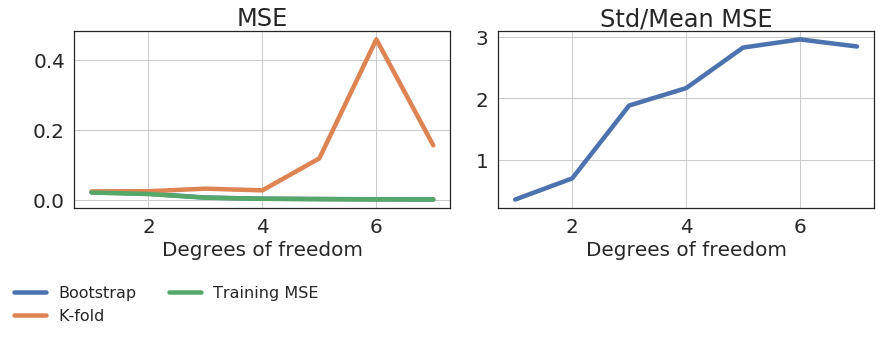

In [64]:
fig, (ax,ax2) = plt.subplots(1,2, figsize=(12.5,5))  # 1 row, 2 columns
fontSize  = 16
legends = ['Bootstrap', 'K-fold', 'Training MSE'] #, 'Bootstrap MSE', 'K-fold MSE'
mseMethods = mseBS, mseKF, mseTraining
r2Methods = r2BS,r2KF , R2training
xTicks = np.arange(2,maxDegree+1, 2)

for mseMethod, r2Method, label in zip(mseMethods, r2Methods, legends): # mseTrainingBS, mseTrainingKF,
    ax.plot(degrees, mseMethod)#, label=label)
    #ax2.plot(degrees, r2Method)#, label=label)
ax2.plot(degrees, mseKFStd)#, label=label)

ax.set_title('MSE', fontsize = fontSize*1.5)
ax2.set_title('Std/Mean MSE', fontsize = fontSize*1.5)
ax.set_xlabel('Degrees of freedom', fontsize = fontSize*1.25)
ax2.set_xlabel('Degrees of freedom', fontsize = fontSize*1.25)
ax.set_xticks(xTicks)
ax2.set_xticks(xTicks)


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
ax.legend(legends, loc='center left', bbox_to_anchor=(-0.2, -0.55), \
           fontsize = fontSize, ncol=2)
ax.tick_params(axis='both', which='major', labelsize=fontSize*1.25)


box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
#ax2.legend(legends, loc='center left', bbox_to_anchor=(-0.2, -0.55), \
           #fontsize = fontSize, ncol=2)
ax2.tick_params(axis='both', which='major', labelsize=fontSize*1.25)
seaborn.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4.5})
plt.tight_layout()

The figure to the left above shows that for the training set the MSE always decreases with the degrees of freedom. We also see that the K-fold method gives higher MSE compared to the training set. The best polynomial degree seems to be everything below 5, since the MSE of the K-fold method is pretty constant in this range. <br>

The reason for the increase in MSE with complexity has to do with increased variance due with model complexity. When the model is complex, a small change in the data will affect the estimation results to a high degree. Hence the MSE will vary a lot between the different folds in the K-fold validations when the model is complex. This phenomenon we can see from the figure above to the right, which shows that the standard deviation relative to the mean MSE increases drastically with the degrees of freedom. <br>

The increase in variance happens from the first degrees of freedom, while the MSE for the K-fold approach does not seem to increase for the first degrees of freedom. The increase in variance, which increases MSE, is countered by a reduction in bias when the degree increase. With increasing degree, the difference between the tru function and the averaged estimated function, giving the bias, is often reduced.

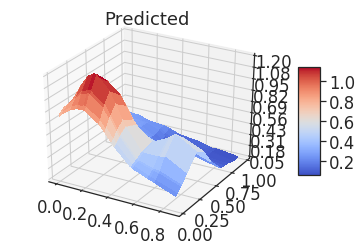

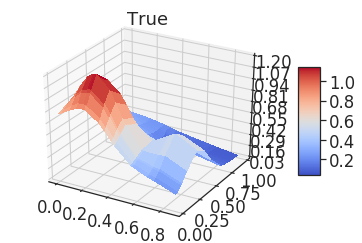


 np.mean(ls.mseBootstrap) 
 0.0014645847563403683 


 bias2, variance, noise, sum(bias2, variance, noise), totalError 0.048468060103545554 0.0011962181862682953 0.0 0.04966427828981385 0.0014968570388459244


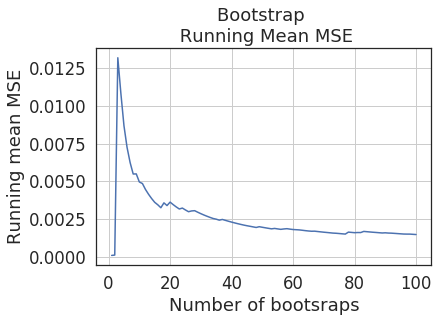

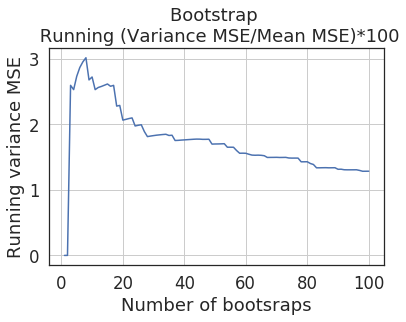

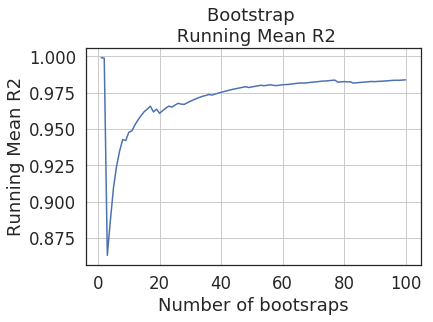

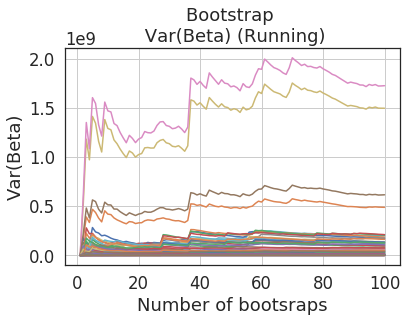

In [12]:
# Testing class

'''
x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)
'''
np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

xPlot, yPlot = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

zPlot = FrankeFunction(xPlot, yPlot)
degree = 10
ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
ls.createDesignMatrix()

ls.estimate()
#ls.fit()
ls.predict()
ls.plot()
ls.calculateErrorScores()
ls.calculateVarianceBeta()

#print('\n Theoretical Var(beta) training set \n', ls.varBeta, '\n')
ls.errorBootstrap(bootstraps=100, plot=True)

print('\n np.mean(ls.mseBootstrap) \n', np.mean(ls.mseBootstrap), '\n')

print('\n bias2, variance, noise, sum(bias2, variance, noise), totalError', 
              ls.bias2, ls.variance, ls.noise, ls.bias2+ ls.variance+ls.noise, ls.totalError)

#print('\n Bootstrap Var(Beta) \n', ls.varianceBetaBootstrap[-1], '\n')

#print('\n Variance diagonal', ls.varOLS, '\n')


#np.savetxt('XHat', ls.XHat)

#print('\n Var(Beta): (boot/theory-1)*100 \n', (ls.varianceBetaBootstrap[-1]/ls.varBeta-1)*100, '\n')

#print('\n (MSEtotal VBT/MSE-1)*100 \n', (ls.VBT/ls.mseBootstrap-1)*100)

#print('\n (MSEtotal VBT/erro2-1)*100 \n', (ls.VBT/ls.error2-1)*100)


The plot above shows tha there is a huge difference between the predicted and the true solution in a small area of the domain. At most the predicted solution is approximately 20 times larger than the true solution. The error scores are very good. However, looking at the figure above, we see that low error scores are no guarantee for the fit being good over the whole domain.

## Bias-variance trade-off
### Bootstrap Bias-variance

/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:251: RuntimeWarning: Mean of empty slice
/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:252: RuntimeWarning: Degrees of freedom <= 0 for slice.
/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:257: RuntimeWarning: Mean of empty slice
/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:259: RuntimeWarning: Mean of empty slice



 bias [0.07855820061228831, 0.07883308743615246, 0.07870390401893108, 0.11408799866524003, 0.13861592677079176, 0.16769581668097913, 0.1706964247572531, 0.1765162626741842, 0.19918973351912267, 0.18823633971032178, 0.21147972428827316, 0.19215266918569177, 4.678216429049978, 16.39652048836759] 
 variance [0.0008977027631585983, 0.001338124183702607, 0.002344106022110967, 0.002716921844474941, 0.0038250792587904234, 0.0028934705576760446, 0.004489173517203135, 0.003377956987781016, 0.00783324361065676, 0.009033557455083704, 0.03732868292022713, 0.03230834571649178, 6.779568428133206, 40.863810676761425] 
 noise [0.1710151049826209, 0.17098738681173667, 0.171079991146344, 0.17082349742412475, 0.17065239141351923, 0.17134052693570168, 0.17175469478100747, 0.17145107555545233, 0.1702326859885246, 0.1708383568860863, 0.16742692667731293, 0.1718332181995997, 0.16949017604116287, 0.17074940082234208] 
 totalError [0.16789903912280693, 0.14719216430694887, 0.14013292187393572, 0.1277274192343

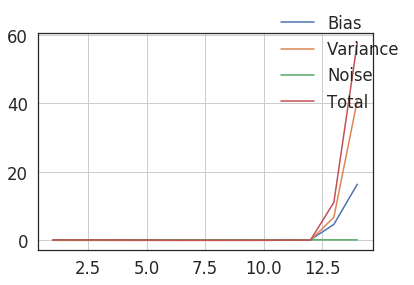

In [14]:
np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)

def frankeNoise(z, noiseSize):
    return z+ noiseSize*np.random.randn(len(z))

noiseSize  = 0.5

zPlot = frankeNoise(zPlot, noiseSize)

maxDegree = 15
degrees = np.arange(1, maxDegree)
bootstraps = 10
bias, variance, noise, totalError = [], [], [], []
for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    #ls.createDesignMatrix()
    #ls.estimate()
    #ls.predict()
    #ls.plot()
    #ls.calculateErrorScores()
    #ls.calculateVarianceBeta()
    ls.errorBootstrap(bootstraps=bootstraps, plot=False)
    bias.append(ls.bias2)
    variance.append(ls.variance)
    noise.append(ls.noise)
    totalError.append(ls.totalError)
print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError, )

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

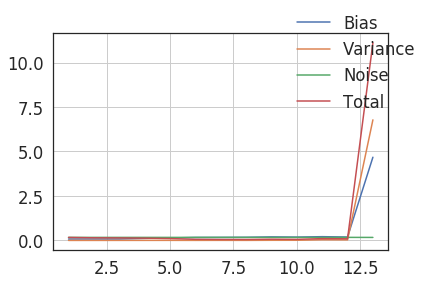

In [18]:
fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees[:-1], variables[i][:-1], label=legends[i][:-1])
fig.legend(legends)

### K-fold bias-variance

Scores: [7.57344301e-01 9.02314094e-05 3.30508203e-05 5.75798496e-05
 3.30379121e-04 1.14593193e-04 1.77685149e-04 9.83613980e-04
 2.69014016e-03 1.86938915e+02]
Mean: 18.770073645372296
Standard deviation: 56.056734500419694

 bias [0.05231905499818193, 0.05087077636322805, 0.07260701511127321, 0.07595821527455154, 0.16794332596679692, 0.5023742241315416, 0.20119253226422346, 2.2789582989304726, 1.5520006717876236, 18.78741602111141] 
 variance [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
 noise [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
 totalError [0.023597971471673956, 0.024114605358293274, 0.031493417426785256, 0.026590736682582022, 0.11831234088999533, 0.45889431887642873, 0.15532443594195977, 2.2248151040476345, 1.5058034591630767, 18.770073645372296]


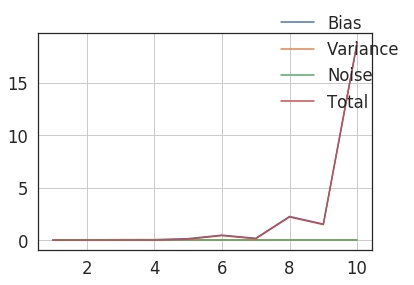

In [19]:
# Testing K-fold

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)
xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)

maxDegrees = 10
degrees = np.arange(1,maxDegrees+1)
bias, variance, noise, totalError = [], [], [], []
for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    #ls.createDesignMatrix()
    #ls.estimate()
    #ls.predict()
    ls.kFold(numberOfFolds=10)
    ls.mseSciKit
    bias.append(ls.bias2)
    variance.append(ls.variance)
    noise.append(ls.noise)
    totalError.append(ls.totalError)    
display_scores(ls.mseSciKit)

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError, )


### Bootstrap other function


 bias [6.460977729012354, 6.4247868285625485, 7.410308058939734, 10.043661354721847, 10.410892584660855, 10.682347113315762, 10.680927219466508, 12.943143762327235, 13.13348077278737, 17.171096058428393] 
 variance [0.36348175514425096, 0.4206319645108042, 0.6690003924354321, 0.9285413633280574, 1.3231919939058003, 1.9739625064603155, 3.2036237096114455, 3.457993689373818, 12.43350404956437, 36.08877429037024] 
 noise [34.68986790195638, 34.68986790195638, 34.68986790195638, 34.68986790195638, 34.68986790195638, 34.68986790195638, 34.68986790195638, 34.68986790195638, 34.68986790195638, 34.68986790195638] 
 totalError [40.64730466590745, 29.684404784607935, 29.154477939417575, 27.126700903344737, 27.887594557863576, 29.0589809647957, 31.527373684409927, 29.60387807293944, 39.401706001604296, 63.88545938557241] 
 totalErrorForTesting [41.514327386113, 41.53528669502975, 42.76917635333155, 45.6620706200063, 46.42395248052304, 47.346177521732464, 48.57441883103434, 51.091005353657444, 60

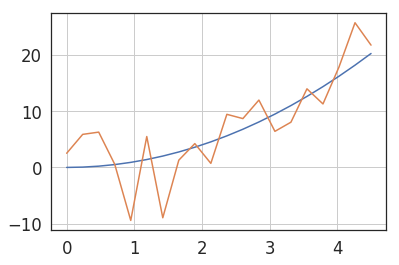

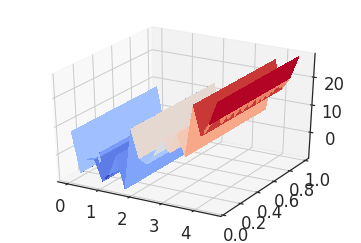

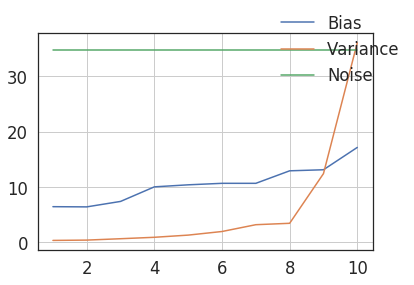

In [136]:
# Testing other function
def f(x, y):
    #z = 2 * np.sin(x * 1.5)
    z = x**2
    return z

def fWithNoise(z):
    z = z+ 5.*np.random.randn(len(z))
    return z

observationNumber = 20
x = np.linspace(0, 4.5, observationNumber)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

fig, ax  = plt.subplots()
z2 = f(x,y)
ax.plot(x, z2)
ax.plot(x, fWithNoise(z2))


xPlot, yPlot = np.meshgrid(x,y)
zPlot = f(xPlot, yPlot)
zPlot = fWithNoise(zPlot)


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, zPlot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



maxDegrees = 11
degrees = np.arange(1, maxDegrees)
bootstraps = 100
bias, variance, noise, totalError, totalErrorForTesting, totalError2 = [], [], [], [], [], []
for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=f)
    #ls.createDesignMatrix()
    #ls.estimate()
    #ls.fit()
    #ls.predict()
    #ls.plot()
    #ls.calculateErrorScores()
    #ls.calculateVarianceBeta()
    ls.errorBootstrap(bootstraps=bootstraps, plot=False)
    bias.append(ls.bias2)
    variance.append(ls.variance)
    noise.append(ls.noise)
    totalError.append(ls.totalError)
    totalErrorForTesting.append(ls.totalErrorForTesting)
    totalError2.append(ls.error2)
print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError, \
      '\n totalErrorForTesting', totalErrorForTesting, '\n totalError2', totalError2, )

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

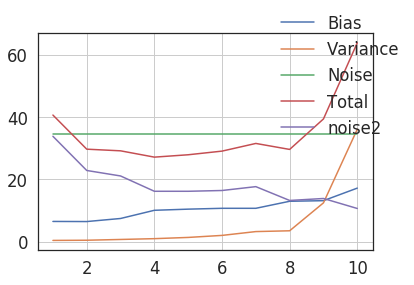

In [141]:
fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total', 'noise2']
noiseFromOther = [totalError[i]-(bias[i] + variance[i]) for i in range(len(totalError))]
variables = [bias, variance, noise, totalError, noiseFromOther]

for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

# Ridge

In [142]:
degree = 10
lambdaValues = 0, .1, 1., 10, 100
for lambdaValue in lambdaValues:
    print('\n Lambda %.2f' %lambdaValue, '\n')
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction, lambdaValue=lambdaValue)
    ls.createDesignMatrix()
    ls.estimate()
    #print('betaHat my class: \n', ls.betaHat)
    ls.predict()
    ls.calculateErrorScores()


 Lambda 0.00 

Mean squared error: 19.5703
R2 score: 0.8105

 Lambda 0.10 

Mean squared error: 23.1529
R2 score: 0.7758

 Lambda 1.00 

Mean squared error: 23.7017
R2 score: 0.7705

 Lambda 10.00 

Mean squared error: 24.7083
R2 score: 0.7608

 Lambda 100.00 

Mean squared error: 26.5546
R2 score: 0.7429


In [56]:
# Ridge and bootstrap
maxDegrees = 10
degrees = np.arange(1, maxDegrees)
bootstraps = 100
bias, variance, noise, totalError, totalErrorForTesting, totalError2 = [], [], [], [], [], []
lambdaValues = 0, 10
noiseValues = 0, 0.5
for noiseValue in noiseValues:
    print('\n Noise: %.2f' %noiseValue, '\n')
    zPlotInput = frankeNoise(zPlot, noiseValue)
    for lambdaValue in lambdaValues:
        print('\n Lambda %.2f' %lambdaValue, '\n')
        for degree in degrees:
            ls = LeastSquares(xPlot, yPlot, zPlotInput, degree,trueFunction=FrankeFunction, lambdaValue=lambdaValue)
            #ls.createDesignMatrix()
            #ls.estimate()
            #ls.predict()
            #ls.plot()
            #ls.calculateErrorScores()
            #ls.calculateVarianceBeta()
            ls.errorBootstrap(bootstraps=bootstraps, plot=False)
            bias.append(ls.bias2)
            variance.append(ls.variance)
            noise.append(ls.noise)
            totalError.append(ls.totalError)
        print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError,'\n' )


 Noise: 0.00 


 Lambda 0.00 


 bias [0.020752055062280107, 0.01663575189760486, 0.0058842216464927224, 0.0026827304984881795, 0.001574837635163821, 0.0007651658524831409, 0.0005061962779104066, 0.00032920193978261424, 0.0007612100705668432] 
 variance [0.00019703927582549147, 0.00027854219117030214, 0.0001702517268844755, 0.00017231670198249527, 0.0001691164655527666, 0.0003106347550999, 0.0003221198861114912, 0.0003193882604039804, 0.0019148736185666526] 
 noise [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 
 totalError [0.020949094338105597, 0.01691429408877516, 0.0060544733733771975, 0.002855047200470675, 0.0017439541007165877, 0.001075800607583041, 0.0008283161640218979, 0.0006485902001865946, 0.0026760836891334956] 


 Lambda 10.00 


 bias [0.020752055062280107, 0.01663575189760486, 0.0058842216464927224, 0.0026827304984881795, 0.001574837635163821, 0.0007651658524831409, 0.0005061962779104066, 0.00032920193978261424, 0.0007612100705668432, 0.029263310496706118, 0.026076975021

# Sci-kit learn comparisons
This section includes comparison of our own methods with corresponding Sci-Kit learn methods.

## Linreg

################### Sci-kit learn############################
Intercept:  0.8240973659564479
Coefficients:  [ 6.05940760e-09 -3.12043822e+00 -2.04351648e+00  4.60435974e+01
  5.56035630e+01  3.02807407e+01 -2.20968238e+02 -2.43795827e+02
 -2.09677399e+02 -1.48194377e+02  4.44942088e+02  4.34315115e+02
  6.91114425e+02  3.56060494e+02  2.95207523e+02 -4.11738038e+02
 -4.23955473e+02 -7.80426685e+02 -7.59964224e+02 -4.01591141e+02
 -2.61183407e+02  1.52527117e+02  2.68618480e+02  2.62716755e+02
  7.00470844e+02  3.01086137e+02  3.06084510e+02  8.42758003e+01
 -8.22924166e+00 -9.04889136e+01  2.19137737e+01 -1.94735897e+02
 -1.52296559e+02 -3.91227650e+01 -1.01928629e+02  1.14757139e+00]
Mean squared error: 0.0005
R2 score: 0.9936

################### My class############################
betaHat my class:  [   0.82409737   -3.12043822   -2.04351648   46.0435974    55.60356304
   30.28074066 -220.96823807 -243.79582695 -209.67739943 -148.19437664
  444.94208756  434.31511529  691.11442499 

/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


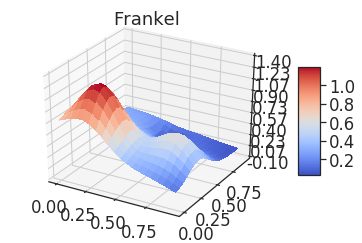

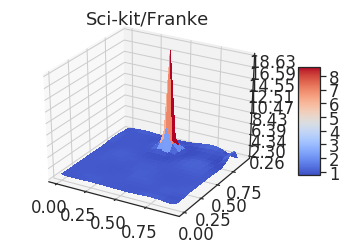

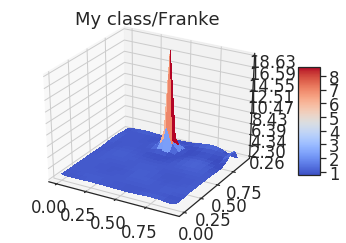

In [65]:
# Scitkit learn. Testing whether our code gives the same mse and R2 on the training set as scl.
from sklearn.linear_model import LinearRegression

x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)

xPlot, yPlot = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

zPlot = FrankeFunction(xPlot, yPlot)

x = np.reshape(xPlot, -1, 1)
y = np.reshape(yPlot, -1, 1)
z = np.reshape(zPlot, -1, 1)


XHat = np.c_[x, y]
degree = 7
polynomialDegree = degree
poly = PolynomialFeatures(polynomialDegree)
XHat = poly.fit_transform(XHat)

print('################### Sci-kit learn############################')
linreg = LinearRegression()
linreg.fit(XHat, z)
predictScitKit = linreg.predict(XHat)


print('Intercept: ', linreg.intercept_)
print('Coefficients: ', linreg.coef_)
print("Mean squared error: %.4f" % mean_squared_error(z, predictScitKit))
print('R2 score: %.4f' % r2_score(z, predictScitKit))

print('\n################### My class############################')

ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
ls.createDesignMatrix()
ls.estimate()
print('betaHat my class: ', ls.betaHat)
ls.predict()
ls.calculateErrorScores()
print('Predictions: zPredict/predictScitKit \n', ls.zPredict/predictScitKit)
print('XHat my class from outside/Xhat before into class \n', ls.XHat/XHat)


##############################PLOTS###################################
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, zPlot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Frankel')
plt.show()

predictScitKitPlot = np.reshape(predictScitKit, np.shape(yPlot)).T
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, predictScitKitPlot/zPlot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Sci-kit/Franke')
plt.show()

predictMyClassPlot = np.reshape(ls.zPredict, np.shape(yPlot)).T
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, predictMyClassPlot/zPlot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('My class/Franke')
plt.show()

### K-fold: MSE. Own vs sci-kit


 Manually calculated MSE/ MSE sci-kit-function  
 [1. 1. 1. 1. 1. 1. 1.]


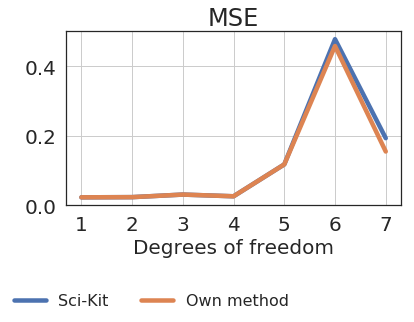

In [46]:
# Sci-kit learn Cross validation

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

#x = np.linspace(0,1,5)
#y = np.linspace(0,1,5)
xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)
x = np.reshape(xPlot, -1, 1)
y = np.reshape(yPlot, -1, 1)
z = np.reshape(zPlot, -1, 1)


def display_scores(scores):
    #print("Scores:", scores)
    #print("Mean:", scores.mean())
    #print("Standard deviation:", scores.std())
    return  scores.mean(), scores.std()

mses = []
mseKF = []
error = []
maxDegrees = 7
numberOfFolds = 10
linreg = LinearRegression()

for degree in range(1, maxDegrees+1):
    poly = PolynomialFeatures(degree)
    XHat = np.c_[x, y]
    XHat = poly.fit_transform(XHat)
    lin_scores = cross_val_score(linreg, XHat, z,
                             scoring="neg_mean_squared_error", cv=numberOfFolds)
    lin_rmse_scores = -lin_scores
    mse, std = display_scores(lin_rmse_scores)
    mses.append(mse)
    
    lsKF = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    lsKF.kFold(numberOfFolds=numberOfFolds)
    mseKF.append(np.mean(lsKF.mseSciKit))
    error.append(lsKF.totalError)

print('\n Manually calculated MSE/ MSE sci-kit-function  \n', np.array(error)/np.array(mseKF))
    
degrees = np.arange(1, maxDegrees+1)
fig, ax = plt.subplots()
legends = ['Sci-Kit', 'Own method']#
methods = mses, mseKF#, error
for degree, method, label in zip(range(1, maxDegrees+1), methods, legends):
    ax.plot(degrees, method, label=label)
#fig.legend(legends)


ax.set_title('MSE', fontsize = fontSize*1.5)
ax.set_xlabel('Degrees of freedom', fontsize = fontSize*1.25)
ax.set_xticks(degrees)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
ax.legend(legends, loc='center left', bbox_to_anchor=(-0.2, -0.55), \
           fontsize = fontSize, ncol=2)
ax.tick_params(axis='both', which='major', labelsize=fontSize*1.25)